In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import timedelta
import pmdarima as pm
from pmdarima.arima import auto_arima
%matplotlib inline

In [4]:
# function for reading the csv
global location
location = "Melbourne Central"
def new_read(csv):
    df = pd.read_csv(csv)
    df = df[["Date","Hour",location]]
    df[location] = pd.to_numeric(df[location],errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df['Date'] = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')
    df = df[["Date",location]]
    df.set_index("Date", drop=True, inplace=True)
    return df

In [5]:

files = os.path.join("C:\\Users\\petrillo\\Desktop\\dani\\HWSWBG2\\dataset\\monthly\\", "ds*.csv")
files = glob.glob(files)
df = pd.concat(map(new_read, files))
print(df)


                     Melbourne Central
Date                                  
2022-02-01 00:00:00                237
2022-02-01 01:00:00                173
2022-02-01 02:00:00                 92
2022-02-01 03:00:00                 36
2022-02-01 04:00:00                 42
...                                ...
2022-03-31 19:00:00               1767
2022-03-31 20:00:00               1461
2022-03-31 21:00:00               1433
2022-03-31 22:00:00               1054
2022-03-31 23:00:00                668

[1416 rows x 1 columns]


In [6]:
df = df.dropna()
df

,Melbourne Central
Date,
2022-02-01 00:00:00,237
2022-02-01 01:00:00,173
2022-02-01 02:00:00,92
2022-02-01 03:00:00,36
2022-02-01 04:00:00,42
...,...
2022-03-31 19:00:00,1767
2022-03-31 20:00:00,1461
2022-03-31 21:00:00,1433


<AxesSubplot:xlabel='Date'>

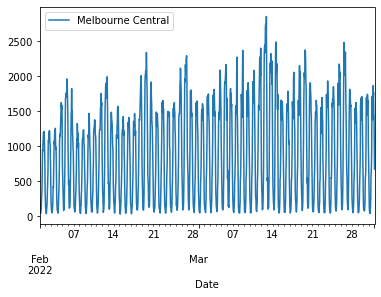

In [7]:
df.plot(kind = 'line')

In [8]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.01, False)

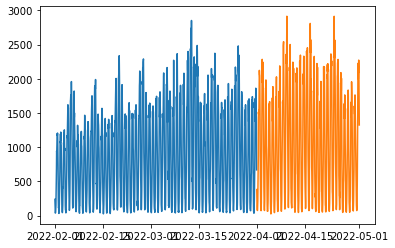

In [14]:
# Alternative
train = df
test = new_read("..\April_2022.csv") 
plt.plot(train)
plt.plot(test)

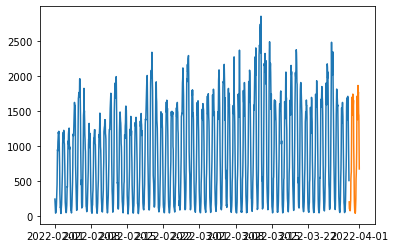

In [19]:
train = df[:-48]
test = df[-48:]
plt.plot(train)
plt.plot(test)

In [20]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0,max_p=5, max_d=5, max_q=5, start_P=0,D=1, start_Q=0, max_P=5, max_D=5,max_Q=5,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True, stepwise=True, random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=20060.058, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=17368.485, Time=0.75 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=5.74 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=8.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=17363.991, Time=4.92 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=3.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.30 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=18.45 sec
 ARIMA(1

In [22]:
prediction = pd.DataFrame(arima_model.predict(n_periods=48),index=test.index)
prediction.columns = ['predicted_count']
prediction["actual_count"] = test[location]
prediction

,predicted_count,actual_count
Date,,
2022-03-30 00:00:00,251.008659,197
2022-03-30 01:00:00,225.056609,102
2022-03-30 02:00:00,116.431718,95
2022-03-30 03:00:00,131.420660,74
2022-03-30 04:00:00,167.117265,72
2022-03-30 05:00:00,154.253820,71
2022-03-30 06:00:00,197.943015,158
2022-03-30 07:00:00,274.739474,220
2022-03-30 08:00:00,467.156492,520


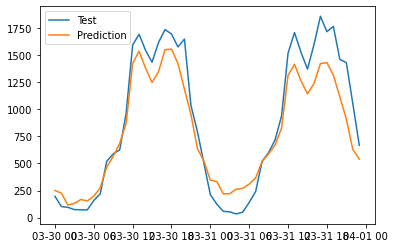

In [23]:
#plt.plot(train, label='Training')
plt.plot(prediction["actual_count"], label='Test')
plt.plot(prediction["predicted_count"], label='Prediction')
plt.legend(loc ='upper left')
plt.show()